# Start

In [170]:
import psycopg2
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [171]:
#Make sure to update inputs to match your Postgres server
conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres"
    #, password = [your password], 
    # port = 5431 [change to postgres port]
)

cursor = conn.cursor()

# VITALS

## Temperature

In [35]:
chart_events_temp_query = '''set search_path to mimiciii;
SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS item_label,
        ce.itemid,
        ce.valuenum
    FROM
        chartevents ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid IN (676, 677, 678, 679, 223761, 223762, 226329)'''

chartevents_temp = pd.read_sql_query(chart_events_temp_query, conn)

chartevents_temp.head()

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2784398667.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  chartevents_temp = pd.read_sql_query(chart_events_temp_query, conn)


,subject_id,hadm_id,icustay_id,charttime,item_label,itemid,valuenum
0,1332,165244,255024.0,2117-12-25 04:00:00,Temperature C,676,36.500000
1,1332,165244,255024.0,2117-12-25 04:00:00,Temperature F (calc),679,97.699997
2,1333,190520,278615.0,2173-09-14 07:00:00,Temperature C (calc),677,37.666698
3,1333,190520,278615.0,2173-09-14 07:00:00,Temperature F,678,99.800003
4,1338,195037,268601.0,2108-12-13 16:00:00,Temperature C (calc),677,37.388901


In [36]:
chartevents_temp_df = chartevents_temp.pivot_table(
    index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
    columns='item_label',
    values='valuenum',
    aggfunc='first'  # Use 'first' as the aggregation function
).reset_index()

# Rename columns to remove multi-level indexing
chartevents_temp_df.columns = [''.join(col).strip() for col in chartevents_temp_df.columns.values]

# Display the pivoted DataFrame
chartevents_temp_df

,subject_id,hadm_id,icustay_id,charttime,Blood Temperature CCO (C),Temperature C,Temperature C (calc),Temperature Celsius,Temperature F,Temperature F (calc),Temperature Fahrenheit
0,3,145834,211552.0,2101-10-20 18:30:00,NaN,NaN,36.055599,NaN,96.900002,NaN,NaN
1,3,145834,211552.0,2101-10-21 01:00:00,NaN,36.200001,36.777802,NaN,98.199997,97.160004,NaN
2,3,145834,211552.0,2101-10-21 02:00:00,NaN,36.200001,NaN,NaN,NaN,97.160004,NaN
3,3,145834,211552.0,2101-10-21 03:00:00,NaN,36.500000,NaN,NaN,NaN,97.699997,NaN
4,3,145834,211552.0,2101-10-21 04:00:00,NaN,36.599998,NaN,NaN,NaN,97.879997,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1797497,99999,113369,246512.0,2118-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,98.0
1797498,99999,113369,246512.0,2118-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,99.1
1797499,99999,113369,246512.0,2117-12-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,99.6
1797500,99999,113369,246512.0,2117-12-31 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,99.7


In [51]:
def pivot_chartevents_table(conn, table_suffix):
    # Construct the table name based on the suffix
    table_name = f'chartevents_{table_suffix}'

    # Query to retrieve temperature-related data
    chart_events_query = f'''SET search_path TO mimiciii;
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS item_label,
        di.unitname AS measurement_type,
        ce.itemid,
        ce.valuenum
    FROM
        {table_name} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid IN (676, 677, 678, 679, 223761, 223762, 226329, 224027, 224642, 224674, 8537, 227054, 228242)'''

    # Read data into a DataFrame
    chartevents_data = pd.read_sql_query(chart_events_query, conn)

    # Check if the DataFrame has rows
    if chartevents_data.empty:
        print(f"No data found for {table_name}. Check your query and data.")
        return None

    # Pivot the DataFrame
    pivoted_df = chartevents_data.pivot_table(
        index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
        columns='item_label',
        values='valuenum',
        aggfunc='first'  # Use 'first' as the aggregation function
    ).reset_index()

    # Rename columns to remove multi-level indexing
    pivoted_df.columns = [''.join(col).strip() for col in pivoted_df.columns.values]

    return pivoted_df


chartevents_6_temp_df = pivot_chartevents_table(conn, 6)
chartevents_13_temp_df = pivot_chartevents_table(conn, 13)



/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/3888035267.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  chartevents_data = pd.read_sql_query(chart_events_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/3888035267.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  chartevents_data = pd.read_sql_query(chart_events_query, conn)


In [38]:
def analyze_missingness(df):
    """
    Analyze the missingness of columns in a DataFrame.

    Parameters:
    - df: DataFrame

    Returns:
    - missing_info: DataFrame
      DataFrame with columns: 'column_name', 'missing_count', 'missing_percentage'
    """
    total_rows = len(df)
    missing_info = []

    for column in df.columns:
        missing_count = df[column].isnull().sum()
        missing_percentage = (missing_count / total_rows) * 100
        missing_info.append([column, missing_count, missing_percentage])

    missing_info = pd.DataFrame(missing_info, columns=['column_name', 'missing_count', 'missing_percentage'])
    missing_info = missing_info.sort_values(by='missing_percentage', ascending=False).reset_index(drop=True)

    return missing_info

# missingness_info = analyze_missingness(chartevents_temp_df)
# print(missingness_info)


In [39]:
missingness_info_6 = analyze_missingness(chartevents_6_temp_df)
print(missingness_info_6)

missingness_info_13 = analyze_missingness(chartevents_13_temp_df)
print(missingness_info_13)

            column_name  missing_count  missing_percentage
0  Temperature F (calc)         768286           67.340759
1         Temperature C         768283           67.340496
2  Temperature C (calc)         370855           32.505678
3         Temperature F         370661           32.488673
4            subject_id              0            0.000000
5               hadm_id              0            0.000000
6            icustay_id              0            0.000000
7             charttime              0            0.000000
              column_name  missing_count  missing_percentage
0     Temperature Celsius         521090           87.552548
1  Temperature Fahrenheit          73153           12.291027
2              subject_id              0            0.000000
3                 hadm_id              0            0.000000
4              icustay_id              0            0.000000
5               charttime              0            0.000000


In [40]:
import pandas as pd

# Assuming df is your DataFrame
# df = pd.read_csv('your_file.csv')  # If you're reading from a CSV file

# Combine the columns
chartevents_temp_df['Temperature_C_all'] = chartevents_temp_df['Temperature C'].combine_first(chartevents_temp_df['Temperature C (calc)']).combine_first(chartevents_temp_df['Temperature Celsius']).combine_first(chartevents_temp_df['Blood Temperature CCO (C)'])
chartevents_temp_df['Temperature_F_all'] = chartevents_temp_df['Temperature F'].combine_first(chartevents_temp_df['Temperature F (calc)']).combine_first(chartevents_temp_df['Temperature Fahrenheit'])

# Drop the old columns
chartevents_temp_df.drop(['Temperature C', 'Temperature C (calc)', 'Temperature Celsius'], axis=1, inplace=True)
chartevents_temp_df.drop(['Temperature F', 'Temperature F (calc)', 'Temperature Fahrenheit'], axis=1, inplace=True)

In [41]:
chartevents_temp_df = chartevents_temp_df.assign(new_temp_c_all = (chartevents_temp_df['Temperature_F_all'] - 32) * 5/9)

In [42]:
chartevents_temp_df['Temperature_final'] = chartevents_temp_df['Temperature_C_all'].combine_first(chartevents_temp_df['new_temp_c_all'])

In [43]:
analyze_missingness(chartevents_temp_df)

,column_name,missing_count,missing_percentage
0,Blood Temperature CCO (C),1735739,96.563954
1,Temperature_C_all,521112,28.990900
2,Temperature_F_all,134682,7.492732
3,new_temp_c_all,134682,7.492732
4,subject_id,0,0.000000
5,hadm_id,0,0.000000
6,icustay_id,0,0.000000
7,charttime,0,0.000000
8,Temperature_final,0,0.000000


In [44]:
chartevents_6_temp_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'Temperature C',
       'Temperature C (calc)', 'Temperature F', 'Temperature F (calc)'],
      dtype='object')

In [52]:
# Combine the columns for chartevents_6_temp_df
chartevents_6_temp_df['Temperature_C_all'] = chartevents_6_temp_df['Temperature C'].combine_first(chartevents_6_temp_df['Temperature C (calc)'])
chartevents_6_temp_df['Temperature_F_all'] = chartevents_6_temp_df['Temperature F'].combine_first(chartevents_6_temp_df['Temperature F (calc)'])

chartevents_6_temp_df.drop(['Temperature C', 'Temperature C (calc)'], axis=1, inplace=True)
chartevents_6_temp_df.drop(['Temperature F', 'Temperature F (calc)'], axis=1, inplace=True)

chartevents_6_temp_df = chartevents_6_temp_df.assign(new_temp_c_all=(chartevents_6_temp_df['Temperature_F_all'] - 32) * 5/9)
chartevents_6_temp_df['Temperature_final'] = chartevents_6_temp_df['Temperature_C_all'].combine_first(chartevents_6_temp_df['new_temp_c_all'])

In [59]:
# Combine the columns
chartevents_13_temp_df['Temperature_C_combined'] = chartevents_13_temp_df['Temperature Celsius']
chartevents_13_temp_df['Temperature_F_combined'] = chartevents_13_temp_df['Temperature Fahrenheit']

# Drop unnecessary columns
chartevents_13_temp_df.drop(['Temperature Celsius', 'Temperature Fahrenheit'], axis=1, inplace=True)

# Convert Fahrenheit to Celsius and create a new column
chartevents_13_temp_df = chartevents_13_temp_df.assign(Temperature_C_converted=(chartevents_13_temp_df['Temperature_F_combined'] - 32) * 5/9)
chartevents_13_temp_df['Temperature_C_final'] = chartevents_13_temp_df['Temperature_C_combined'].combine_first(chartevents_13_temp_df['Temperature_C_converted'])


In [56]:

print(analyze_missingness(chartevents_temp_df))
chartevents_temp_df

                 column_name  missing_count  missing_percentage
0  Blood Temperature CCO (C)        1735739           96.563954
1          Temperature_C_all         521112           28.990900
2          Temperature_F_all         134682            7.492732
3             new_temp_c_all         134682            7.492732
4                 subject_id              0            0.000000
5                    hadm_id              0            0.000000
6                 icustay_id              0            0.000000
7                  charttime              0            0.000000
8          Temperature_final              0            0.000000


,subject_id,hadm_id,icustay_id,charttime,Blood Temperature CCO (C),Temperature_C_all,Temperature_F_all,new_temp_c_all,Temperature_final
0,3,145834,211552.0,2101-10-20 18:30:00,NaN,36.055599,96.900002,36.055556,36.055599
1,3,145834,211552.0,2101-10-21 01:00:00,NaN,36.200001,98.199997,36.777776,36.200001
2,3,145834,211552.0,2101-10-21 02:00:00,NaN,36.200001,97.160004,36.200002,36.200001
3,3,145834,211552.0,2101-10-21 03:00:00,NaN,36.500000,97.699997,36.499998,36.500000
4,3,145834,211552.0,2101-10-21 04:00:00,NaN,36.599998,97.879997,36.599998,36.599998
...,...,...,...,...,...,...,...,...,...
1797497,99999,113369,246512.0,2118-01-01 08:00:00,NaN,NaN,98.000000,36.666667,36.666667
1797498,99999,113369,246512.0,2118-01-01 12:00:00,NaN,NaN,99.100000,37.277778,37.277778
1797499,99999,113369,246512.0,2117-12-31 12:00:00,NaN,NaN,99.600000,37.555556,37.555556
1797500,99999,113369,246512.0,2117-12-31 16:00:00,NaN,NaN,99.700000,37.611111,37.611111


In [57]:
print(analyze_missingness(chartevents_6_temp_df))
chartevents_6_temp_df


         column_name  missing_count  missing_percentage
0  Temperature_C_all            230            0.020160
1  Temperature_F_all             86            0.007538
2     new_temp_c_all             86            0.007538
3         subject_id              0            0.000000
4            hadm_id              0            0.000000
5         icustay_id              0            0.000000
6          charttime              0            0.000000
7  Temperature_final              0            0.000000


,subject_id,hadm_id,icustay_id,charttime,Temperature_C_all,Temperature_F_all,new_temp_c_all,Temperature_final
0,3,145834,211552.0,2101-10-20 18:30:00,36.055599,96.900002,36.055556,36.055599
1,3,145834,211552.0,2101-10-21 01:00:00,36.200001,98.199997,36.777776,36.200001
2,3,145834,211552.0,2101-10-21 02:00:00,36.200001,97.160004,36.200002,36.200001
3,3,145834,211552.0,2101-10-21 03:00:00,36.500000,97.699997,36.499998,36.500000
4,3,145834,211552.0,2101-10-21 04:00:00,36.599998,97.879997,36.599998,36.599998
...,...,...,...,...,...,...,...,...
1140888,32810,189751,204923.0,2100-10-04 02:00:00,37.944401,100.300003,37.944446,37.944401
1140889,32810,189751,204923.0,2100-10-04 04:45:00,39.833302,103.699997,39.833332,39.833302
1140890,32810,189751,204923.0,2100-10-04 10:00:00,37.777802,100.000000,37.777778,37.777802
1140891,32810,189751,204923.0,2100-10-04 14:00:00,39.388901,102.900002,39.388890,39.388901


In [60]:
print(analyze_missingness(chartevents_13_temp_df))
chartevents_13_temp_df

               column_name  missing_count  missing_percentage
0   Temperature_C_combined         521090           87.552548
1   Temperature_F_combined          73153           12.291027
2  Temperature_C_converted          73153           12.291027
3               subject_id              0            0.000000
4                  hadm_id              0            0.000000
5               icustay_id              0            0.000000
6                charttime              0            0.000000
7      Temperature_C_final              0            0.000000


,subject_id,hadm_id,icustay_id,charttime,Temperature_C_combined,Temperature_F_combined,Temperature_C_converted,Temperature_C_final
0,23,124321,234044.0,2157-10-21 12:05:00,NaN,95.8,35.444444,35.444444
1,23,124321,234044.0,2157-10-21 14:00:00,NaN,97.2,36.222222,36.222222
2,23,124321,234044.0,2157-10-21 19:00:00,NaN,96.8,36.000000,36.000000
3,23,124321,234044.0,2157-10-22 00:00:00,NaN,97.6,36.444444,36.444444
4,23,124321,234044.0,2157-10-22 04:00:00,NaN,97.0,36.111111,36.111111
...,...,...,...,...,...,...,...,...
595169,99999,113369,246512.0,2118-01-01 12:00:00,NaN,99.1,37.277778,37.277778
595170,99999,113369,246512.0,2117-12-31 12:00:00,NaN,99.6,37.555556,37.555556
595171,99999,113369,246512.0,2117-12-31 16:00:00,NaN,99.7,37.611111,37.611111
595172,99999,113369,246512.0,2117-12-31 20:00:00,NaN,99.3,37.388889,37.388889


In [61]:
# Specify the path where you want to save the CSV file
csv_path_1 = 'chartevents_temp.csv'
csv_path_2 =  'chartevents_6_temp.csv'
csv_path_3 = 'chartevents_13_temp.csv'

# Save the DataFrame to CSV
chartevents_temp_df.to_csv(csv_path_1, index=False)
chartevents_6_temp_df.to_csv(csv_path_2, index=False)
chartevents_13_temp_df.to_csv(csv_path_3, index=False)

## Respiratory Rate (RR)
respiratory rate is measured in insp/min (inspirations per min aka bpm)

In [82]:
# Replace 'your_conn' with your actual database connection
chart_events_rr_query = '''
SET search_path TO mimiciii;

SELECT
    ce.subject_id,
    ce.hadm_id,
    ce.icustay_id,
    ce.charttime,
    di.label AS item_label,
    ce.itemid,
    ce.valuenum
FROM
    chartevents ce
JOIN
    d_items di ON ce.itemid = di.itemid
WHERE
    di.label ILIKE 'Respiratory Rate%'
    AND ce.valuenum IS NOT NULL;
'''

# Execute the query
chartevents_rr = pd.read_sql_query(chart_events_rr_query, conn)

# Pivot the table
chartevents_rr_df = chartevents_rr.pivot_table(
    index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
    columns='item_label',
    values='valuenum',
    aggfunc='first'
).reset_index()

# Rename columns to remove multi-level indexing
chartevents_rr_df.columns = [''.join(col).strip() for col in chartevents_rr_df.columns.values]

# Display the pivoted DataFrame
chartevents_rr_df.head()

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/3972847867.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  chartevents_rr = pd.read_sql_query(chart_events_rr_query, conn)


,subject_id,hadm_id,icustay_id,charttime,Respiratory Rate,Respiratory Rate (Set),Respiratory Rate (Total),Respiratory Rate (spontaneous),Respiratory Rate Set
0,3,145834,211552.0,2101-10-20 18:45:00,16.0,NaN,NaN,NaN,NaN
1,3,145834,211552.0,2101-10-20 20:00:00,NaN,NaN,NaN,NaN,16.0
2,3,145834,211552.0,2101-10-20 20:15:00,5.0,NaN,NaN,NaN,NaN
3,3,145834,211552.0,2101-10-20 20:30:00,21.0,NaN,NaN,NaN,NaN
4,3,145834,211552.0,2101-10-20 20:45:00,21.0,NaN,NaN,NaN,NaN


<Figure size 1008x576 with 0 Axes>

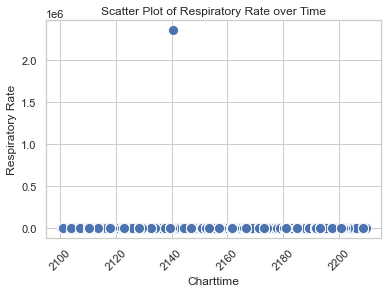

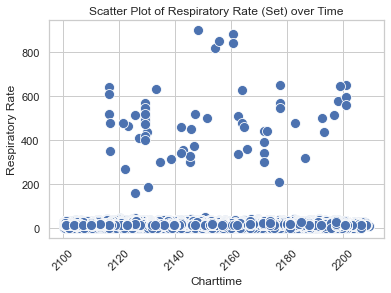

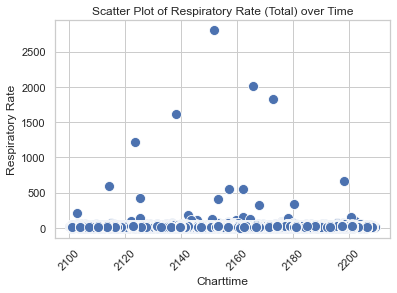

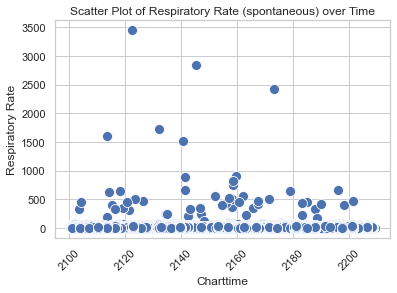

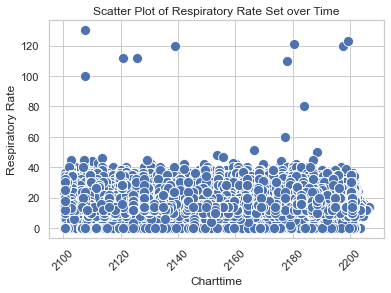

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Assuming the columns are 'Respiratory Rate', 'Respiratory Rate (Set)', 'Respiratory Rate (Total)', 'Respiratory Rate (spontaneous)', 'Respiratory Rate Set', 'charttime'

# Melt the DataFrame to long format for easier plotting
melted_df = pd.melt(chartevents_rr_df, id_vars=['charttime'], value_vars=['Respiratory Rate', 'Respiratory Rate (Set)', 'Respiratory Rate (Total)', 'Respiratory Rate (spontaneous)', 'Respiratory Rate Set'], var_name='Measurement')

# Plot scatter plots for each column
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

for measurement_type in melted_df['Measurement'].unique():
    plt.figure()
    sns.scatterplot(x='charttime', y='value', data=melted_df[melted_df['Measurement'] == measurement_type], s=100, marker='o')
    
    # Customize the plot
    plt.title(f'Scatter Plot of {measurement_type} over Time')
    plt.ylabel('Respiratory Rate')
    plt.xlabel('Charttime')
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()




In [86]:
diff_1 = abs(chartevents_rr_df['Respiratory Rate'] - chartevents_rr_df['Respiratory Rate (Set)']).sum()
diff_2 = abs(chartevents_rr_df['Respiratory Rate'] - chartevents_rr_df['Respiratory Rate (Total)']).sum()
diff_3 = abs(chartevents_rr_df['Respiratory Rate'] - chartevents_rr_df['Respiratory Rate (spontaneous)']).sum()

diff_1, diff_2, diff_3



(746379.5, 1251041.7000000002, 4135488.76)

In [6]:
# Combine respiratory rate columns
chartevents_rr_df['RespiratoryRate_combined'] = (
    chartevents_rr_df['Respiratory Rate']
    .combine_first(chartevents_rr_df['Respiratory Rate (Set)'])
    .combine_first(chartevents_rr_df['Respiratory Rate (Total)'])
    .combine_first(chartevents_rr_df['Respiratory Rate (spontaneous)'])
    .combine_first(chartevents_rr_df['Respiratory Rate Set'])
)

chartevents_rr_df.head()


,subject_id,hadm_id,icustay_id,charttime,Respiratory Rate,Respiratory Rate (Set),Respiratory Rate (Total),Respiratory Rate (spontaneous),Respiratory Rate Set,RespiratoryRate_combined
0,3,145834,211552.0,2101-10-20 18:45:00,16.0,NaN,NaN,NaN,NaN,16.0
1,3,145834,211552.0,2101-10-20 20:00:00,NaN,NaN,NaN,NaN,16.0,16.0
2,3,145834,211552.0,2101-10-20 20:15:00,5.0,NaN,NaN,NaN,NaN,5.0
3,3,145834,211552.0,2101-10-20 20:30:00,21.0,NaN,NaN,NaN,NaN,21.0
4,3,145834,211552.0,2101-10-20 20:45:00,21.0,NaN,NaN,NaN,NaN,21.0


In [18]:
analyze_missingness(chartevents_rr_df)

,column_name,missing_count,missing_percentage
0,Respiratory Rate (Set),6043912,96.497785
1,Respiratory Rate Set,6017850,96.081676
2,Respiratory Rate (Total),5863602,93.618935
3,Respiratory Rate (spontaneous),5810386,92.769282
4,Respiratory Rate,144655,2.309578
5,subject_id,0,0.000000
6,hadm_id,0,0.000000
7,icustay_id,0,0.000000
8,charttime,0,0.000000
9,RespiratoryRate_combined,0,0.000000


In [28]:
def process_respiratory_rate_table(table_name, conn):
    # Construct the query for respiratory rates
    respiratory_rate_query = f'''
    SET search_path TO mimiciii;

    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS item_label,
        di.unitname AS measurement_type,
        di.dbsource AS label_meaning,
        ce.valuenum
    FROM
        {table_name} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        di.label ILIKE 'Respiratory Rate%'
        AND ce.valuenum IS NOT NULL;
    '''

    # Execute the query
    respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)

    if respiratory_rate_df.empty:
        print(f"{table_name} has no rr values")

    else:

        # Pivot the table
        respiratory_rate_df = respiratory_rate_df.pivot_table(
            index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
            columns='item_label',
            values='valuenum',
            aggfunc='first'
        ).reset_index()

        # Rename columns to remove multi-level indexing
        respiratory_rate_df.columns = [''.join(col).strip() for col in respiratory_rate_df.columns.values]

        # Combine respiratory rate columns dynamically
        respiratory_rate_cols = [col for col in respiratory_rate_df.columns if 'Respiratory Rate' in col]
        respiratory_rate_df['RespiratoryRate_combined'] = respiratory_rate_df[respiratory_rate_cols].bfill(axis=1).iloc[:, 0]

        # Drop unnecessary columns
       #respiratory_rate_df.drop(respiratory_rate_cols, axis=1, inplace=True)

        # Impute missing values if needed
        respiratory_rate_df['RespiratoryRate_combined'] = respiratory_rate_df['RespiratoryRate_combined']

        return respiratory_rate_df

In [8]:
# Loop through chartevents_1 to chartevents_17
# for i in range(1, 18):
#     table_name = f'chartevents_{i}'
#     table_df = process_respiratory_rate_table(table_name, conn)

#     if isinstance(table_df, pd.DataFrame):
#         # Display the processed table
#         print(f'\nProcessed Table: {table_name}')
#         print(table_df.head())
#     else:
#         print("Variable is not a pandas DataFrame")

       

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_1 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_2 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_3 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_4 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)



Processed Table: chartevents_5
   subject_id  hadm_id  icustay_id           charttime  \
0           3   145834    211552.0 2101-10-20 18:45:00   
1           3   145834    211552.0 2101-10-20 20:00:00   
2           3   145834    211552.0 2101-10-20 20:15:00   
3           3   145834    211552.0 2101-10-20 20:30:00   
4           3   145834    211552.0 2101-10-20 20:45:00   

   RespiratoryRate_combined  
0                      16.0  
1                      16.0  
2                       5.0  
3                      21.0  
4                      21.0  


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_6 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_7 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_8 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_9 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_10 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_11 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)



Processed Table: chartevents_12
   subject_id  hadm_id  icustay_id           charttime  \
0          23   124321    234044.0 2157-10-21 12:06:00   
1          23   124321    234044.0 2157-10-21 13:00:00   
2          23   124321    234044.0 2157-10-21 14:00:00   
3          23   124321    234044.0 2157-10-21 15:00:00   
4          23   124321    234044.0 2157-10-21 16:17:00   

   RespiratoryRate_combined  
0                      14.0  
1                      18.0  
2                      11.0  
3                      13.0  
4                      13.0  


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_13 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_14 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)



Processed Table: chartevents_15
   subject_id  hadm_id  icustay_id           charttime  \
0          34   144319    290505.0 2191-02-23 07:00:00   
1          34   144319    290505.0 2191-02-23 07:31:00   
2          34   144319    290505.0 2191-02-23 11:00:00   
3          36   165660    241249.0 2134-05-12 16:00:00   
4          36   165660    241249.0 2134-05-12 21:00:00   

   RespiratoryRate_combined  
0                      22.0  
1                      14.0  
2                      11.0  
3                      20.0  
4                      18.0  


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_16 has no rr values
Variable is not a pandas DataFrame


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1063543478.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


chartevents_17 has no rr values
Variable is not a pandas DataFrame


In [29]:
chartevents_5_rr_df = process_respiratory_rate_table('chartevents_5', conn)
chartevents_12_rr_df = process_respiratory_rate_table("chartevents_12", conn)
chartevents_15_rr_df = process_respiratory_rate_table('chartevents_15', conn)

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1024084153.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


In [30]:
chartevents_12_rr_df = process_respiratory_rate_table("chartevents_12", conn)
chartevents_15_rr_df = process_respiratory_rate_table('chartevents_15', conn)

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1024084153.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1024084153.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  respiratory_rate_df = pd.read_sql_query(respiratory_rate_query, conn)


In [65]:
analyze_missingness(chartevents_5_rr_df)
chartevents_5_rr_df


,subject_id,hadm_id,icustay_id,charttime,Respiratory Rate,Respiratory Rate Set,RespiratoryRate_combined
0,3,145834,211552.0,2101-10-20 18:45:00,16.0,NaN,16.0
1,3,145834,211552.0,2101-10-20 20:00:00,NaN,16.0,16.0
2,3,145834,211552.0,2101-10-20 20:15:00,5.0,NaN,5.0
3,3,145834,211552.0,2101-10-20 20:30:00,21.0,NaN,21.0
4,3,145834,211552.0,2101-10-20 20:45:00,21.0,NaN,21.0
...,...,...,...,...,...,...,...
3470659,32810,189751,204923.0,2100-10-02 16:30:00,24.0,NaN,24.0
3470660,32810,189751,204923.0,2100-10-02 17:30:00,28.0,NaN,28.0
3470661,32810,189751,204923.0,2100-10-02 18:45:00,NaN,0.0,0.0
3470662,32810,189751,204923.0,2100-10-02 23:09:00,NaN,0.0,0.0


In [32]:
analyze_missingness(chartevents_12_rr_df)

,column_name,missing_count,missing_percentage
0,subject_id,0,0.0
1,hadm_id,0,0.0
2,icustay_id,0,0.0
3,charttime,0,0.0
4,Respiratory Rate,0,0.0
5,RespiratoryRate_combined,0,0.0


In [33]:
analyze_missingness(chartevents_15_rr_df)

,column_name,missing_count,missing_percentage
0,Respiratory Rate (Set),267040,54.902106
1,Respiratory Rate (Total),86730,17.831260
2,Respiratory Rate (spontaneous),33514,6.890313
3,subject_id,0,0.000000
4,hadm_id,0,0.000000
5,icustay_id,0,0.000000
6,charttime,0,0.000000
7,RespiratoryRate_combined,0,0.000000


In [66]:
# Specify the path where you want to save the CSV file
csv_path_1 = 'chartevents_rr.csv'
csv_path_2 =  'chartevents_5_rr.csv'
csv_path_3 = 'chartevents_12_rr.csv'
csv_path_4 = 'chartevents_15_rr.csv'


# Save the DataFrame to CSV
chartevents_rr_df.to_csv(csv_path_1, index=False)
chartevents_5_rr_df.to_csv(csv_path_2, index=False)
chartevents_12_rr_df.to_csv(csv_path_3, index=False)
chartevents_15_rr_df.to_csv(csv_path_4, index=False)



##  Blood Pressure

In [95]:
# Blood pressure item IDs
blood_pressure_item_ids = [220179, 51, 6701, 455, 442, 220050]

# Construct the SQL query
blood_pressure_query = f'''SET search_path TO mimiciii;
SELECT
    ce.subject_id,
    ce.hadm_id,
    ce.icustay_id,
    ce.charttime,
    di.label AS blood_pressure_label,
    ce.itemid,
    ce.valuenum
FROM
    chartevents ce
JOIN
    d_items di ON ce.itemid = di.itemid
WHERE
    ce.itemid IN ({', '.join(map(str, blood_pressure_item_ids))})'''

blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)

# Close the database connection
conn.close()

# Check if the DataFrame has rows
if blood_pressure_data.empty:
    print("No data found. Check your query and data.")
else:
    # Pivot the DataFrame
    chartevents_bp_df = blood_pressure_data.pivot_table(
        index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
        columns='blood_pressure_label',
        values='valuenum',
        aggfunc='first'  # Use 'first' as the aggregation function
    ).reset_index()

    # Rename columns to remove multi-level indexing
    chartevents_bp_df.columns = [''.join(col).strip() for col in pivoted_df.columns.values]

    # Display the pivoted DataFrame
    chartevents_bp_df


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2815624556.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)


In [98]:
chartevents_bp_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'charttime',
       'Arterial BP #2 [Systolic]', 'Arterial BP [Systolic]',
       'Arterial Blood Pressure systolic', 'Manual BP [Systolic]',
       'NBP [Systolic]', 'Non Invasive Blood Pressure systolic'],
      dtype='object')

In [111]:
chartevents_bp_df['BP_combined'] = chartevents_bp_df['Arterial BP #2 [Systolic]'].combine_first(chartevents_bp_df['Arterial BP [Systolic]']).combine_first(chartevents_bp_df['Arterial Blood Pressure systolic']).combine_first(chartevents_bp_df['Manual BP [Systolic]']).combine_first(chartevents_bp_df['NBP [Systolic]']).combine_first(chartevents_bp_df['Non Invasive Blood Pressure systolic'])
chartevents_bp_df

,subject_id,hadm_id,icustay_id,charttime,Arterial BP #2 [Systolic],Arterial BP [Systolic],Arterial Blood Pressure systolic,Manual BP [Systolic],NBP [Systolic],Non Invasive Blood Pressure systolic,BP_combined,Combined_Blood_Pressure_Systolic,Combined_Blood_Pressure
0,3,145834,211552.0,2101-10-20 18:45:00,NaN,NaN,NaN,NaN,62.0,NaN,62.0,62.0,62.0
1,3,145834,211552.0,2101-10-20 19:00:00,NaN,NaN,NaN,NaN,66.0,NaN,66.0,66.0,66.0
2,3,145834,211552.0,2101-10-20 19:15:00,NaN,0.0,NaN,NaN,217.0,NaN,0.0,0.0,0.0
3,3,145834,211552.0,2101-10-20 19:30:00,NaN,NaN,NaN,NaN,102.0,NaN,102.0,102.0,102.0
4,3,145834,211552.0,2101-10-20 19:45:00,NaN,NaN,NaN,NaN,94.0,NaN,94.0,94.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5784416,99999,113369,246512.0,2117-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,133.0,133.0,133.0,133.0
5784417,99999,113369,246512.0,2117-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,128.0,128.0,128.0,128.0
5784418,99999,113369,246512.0,2118-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,139.0,139.0,139.0,139.0
5784419,99999,113369,246512.0,2117-12-31 11:59:00,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.0,125.0


In [112]:
analyze_missingness(chartevents_bp_df)

,column_name,missing_count,missing_percentage
0,Manual BP [Systolic],5782146,99.960670
1,Arterial BP #2 [Systolic],5765695,99.676268
2,Arterial Blood Pressure systolic,4634976,80.128608
3,Non Invasive Blood Pressure systolic,4494084,77.692893
4,NBP [Systolic],4210889,72.797070
5,Arterial BP [Systolic],3699370,63.954024
6,subject_id,0,0.000000
7,hadm_id,0,0.000000
8,icustay_id,0,0.000000
9,charttime,0,0.000000


In [118]:
def has_blood_pressure_values(table_suffix):
    # Construct the table name based on the suffix
    table_name = f'chartevents_{table_suffix}'

    # Query to retrieve blood pressure-related data
    bp_query = f'''set search_path to mimiciii;
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS item_label,
        ce.itemid,
        ce.valuenum
    FROM
        {table_name} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid IN (220179, 51, 6701, 455, 442, 220050)'''

    # Read data into a DataFrame
    bp_data = pd.read_sql_query(bp_query, conn)

    # Check if the DataFrame has rows with blood pressure values
    return not bp_data.empty

# Iterate over chartevents_1 to chartevents_17
bp_vals = []
for table_suffix in range(1, 18):
    has_bp_values = has_blood_pressure_values(table_suffix)
    if has_bp_values:
        bp_vals.append(f'chartevents_{table_suffix}')



/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1718614485.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bp_data = pd.read_sql_query(bp_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1718614485.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bp_data = pd.read_sql_query(bp_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1718614485.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bp_data = pd.read_sql_query(bp_query, conn)
/var/folde

In [119]:
bp_vals

['chartevents_1', 'chartevents_4', 'chartevents_10', 'chartevents_12']

In [120]:

def combine_bp_values_for_tables(table_suffix_list):
    # Initialize an empty DataFrame to store the combined blood pressure values
    combined_bp_df = pd.DataFrame()

    # Iterate over the specified chartevents tables
    for table_suffix in table_suffix_list:
        # Construct the table name based on the suffix
        table_name = f'chartevents_{table_suffix}'

        # Query to retrieve blood pressure-related data
        bp_query = f'''set search_path to mimiciii;
        SELECT
            ce.subject_id,
            ce.hadm_id,
            ce.icustay_id,
            ce.charttime,
            di.label AS item_label,
            ce.itemid,
            ce.valuenum
        FROM
            {table_name} ce
        JOIN
            d_items di ON ce.itemid = di.itemid
        WHERE
            ce.itemid IN (220179, 51, 6701, 455, 442, 220050)'''

        # Read data into a DataFrame
        bp_data = pd.read_sql_query(bp_query, conn)

        # Check if the DataFrame has rows with blood pressure values
        if not bp_data.empty:
            # Combine blood pressure values into a single column
            combined_bp_df = pd.concat([combined_bp_df, bp_data['valuenum']], axis=1)

    return combined_bp_df

# Specify the tables to consider
table_suffix_list = [1, 4, 10, 12]

# Get the combined blood pressure values
combined_bp_values = combine_bp_values_for_tables(table_suffix_list)

# Display the combined DataFrame
print(combined_bp_values)


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1658271208.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bp_data = pd.read_sql_query(bp_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1658271208.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bp_data = pd.read_sql_query(bp_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1658271208.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bp_data = pd.read_sql_query(bp_query, conn)
/var/folde

         valuenum  valuenum  valuenum  valuenum
0           159.0     107.0     101.0     137.0
1           144.0     121.0      83.0     118.0
2           129.0     135.0     133.0     130.0
3           122.0     117.0     103.0     117.0
4           127.0     128.0     150.0     135.0
...           ...       ...       ...       ...
2440271       NaN       NaN       NaN      67.0
2440272       NaN       NaN       NaN     122.0
2440273       NaN       NaN       NaN     119.0
2440274       NaN       NaN       NaN      85.0
2440275       NaN       NaN       NaN      96.0

[2440276 rows x 4 columns]


In [121]:
combined_bp_values

,valuenum,valuenum,valuenum,valuenum
0,159.0,107.0,101.0,137.0
1,144.0,121.0,83.0,118.0
2,129.0,135.0,133.0,130.0
3,122.0,117.0,103.0,117.0
4,127.0,128.0,150.0,135.0
...,...,...,...,...
2440271,NaN,NaN,NaN,67.0
2440272,NaN,NaN,NaN,122.0
2440273,NaN,NaN,NaN,119.0
2440274,NaN,NaN,NaN,85.0


In [129]:
import pandas as pd

# Assuming you have a database connection named conn

def process_chartevents_bp_table(table_suffix):
    # Construct the table name based on the suffix
    table_name = f'chartevents_{table_suffix}'

    # Blood pressure item IDs
    blood_pressure_item_ids = [220179, 51, 6701, 455, 442, 220050]

    # Construct the SQL query
    blood_pressure_query = f'''SET search_path TO mimiciii;
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS blood_pressure_label,
        ce.itemid,
        ce.valuenum
    FROM
        {table_name} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid IN ({', '.join(map(str, blood_pressure_item_ids))})'''

    # Read data into a DataFrame
    blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)

    # Check if the DataFrame has rows
    if blood_pressure_data.empty:
        print(f"No data found for {table_name}. Check your query and data.")
        return None

    # Pivot the DataFrame
    chartevents_bp_df = blood_pressure_data.pivot_table(
        index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
        columns='blood_pressure_label',
        values='valuenum',
        aggfunc='first'  # Use 'first' as the aggregation function
    ).reset_index()

    # Identify blood pressure columns dynamically
    essential_columns = ['subject_id', 'hadm_id', 'icustay_id', 'charttime']
    bp_columns = [col for col in chartevents_bp_df.columns if col not in essential_columns]

    # Check if there are any blood pressure columns
    if not bp_columns:
        print(f"No blood pressure columns found for {table_name}. Check your data.")
        return chartevents_bp_df

    # Combine blood pressure columns into a new column
    chartevents_bp_df['BP_combined'] = chartevents_bp_df[bp_columns].bfill(axis=1).iloc[:, 0]

    return chartevents_bp_df

# Specify the chartevents tables to process
chartevents_tables_to_process = [1, 4, 10, 12]

# Dictionary to store DataFrames for each table
bp_dataframes = {}

# # Iterate over the specified tables
# for table_suffix in chartevents_tables_to_process:
#     # Process the current table
#     bp_dataframes[table_suffix] = process_chartevents_bp_table(table_suffix)

# # Display the processed DataFrames
# for table_suffix, df in bp_dataframes.items():
#     print(f"\nProcessed DataFrame for chartevents_{table_suffix}:\n")
#     print(df)


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2493750816.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2493750816.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2493750816.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  blood_


Processed DataFrame for chartevents_1:

blood_pressure_label  subject_id  hadm_id  icustay_id           charttime  \
0                              3   145834    211552.0 2101-10-20 19:15:00   
1                              3   145834    211552.0 2101-10-20 20:00:00   
2                              3   145834    211552.0 2101-10-20 20:15:00   
3                              3   145834    211552.0 2101-10-20 20:30:00   
4                              3   145834    211552.0 2101-10-20 20:45:00   
...                          ...      ...         ...                 ...   
2085046                    32810   189751    204923.0 2100-09-28 07:30:00   
2085047                    32810   189751    204923.0 2100-09-28 09:15:00   
2085048                    32810   189751    204923.0 2100-09-28 21:15:00   
2085049                    32810   189751    204923.0 2100-09-29 02:30:00   
2085050                    32810   189751    204923.0 2100-09-29 02:45:00   

blood_pressure_label  Arterial BP 

In [130]:
chartevents_1_bp_df = process_chartevents_bp_table(1)
chartevents_1_bp_df 

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2493750816.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)


blood_pressure_label,subject_id,hadm_id,icustay_id,charttime,Arterial BP [Systolic],BP_combined
0,3,145834,211552.0,2101-10-20 19:15:00,0.0,0.0
1,3,145834,211552.0,2101-10-20 20:00:00,78.0,78.0
2,3,145834,211552.0,2101-10-20 20:15:00,73.0,73.0
3,3,145834,211552.0,2101-10-20 20:30:00,77.0,77.0
4,3,145834,211552.0,2101-10-20 20:45:00,88.0,88.0
...,...,...,...,...,...,...
2085046,32810,189751,204923.0,2100-09-28 07:30:00,108.0,108.0
2085047,32810,189751,204923.0,2100-09-28 09:15:00,118.0,118.0
2085048,32810,189751,204923.0,2100-09-28 21:15:00,108.0,108.0
2085049,32810,189751,204923.0,2100-09-29 02:30:00,160.0,160.0


In [131]:
analyze_missingness(chartevents_1_bp_df)

,column_name,missing_count,missing_percentage
0,subject_id,0,0.0
1,hadm_id,0,0.0
2,icustay_id,0,0.0
3,charttime,0,0.0
4,Arterial BP [Systolic],0,0.0
5,BP_combined,0,0.0


In [132]:
chartevents_4_bp_df = process_chartevents_bp_table(4)
chartevents_4_bp_df

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2493750816.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)


blood_pressure_label,subject_id,hadm_id,icustay_id,charttime,Manual BP [Systolic],NBP [Systolic],BP_combined
0,3,145834,211552.0,2101-10-20 18:45:00,NaN,62.0,62.0
1,3,145834,211552.0,2101-10-20 19:00:00,NaN,66.0,66.0
2,3,145834,211552.0,2101-10-20 19:15:00,NaN,217.0,217.0
3,3,145834,211552.0,2101-10-20 19:30:00,NaN,102.0,102.0
4,3,145834,211552.0,2101-10-20 19:45:00,NaN,94.0,94.0
...,...,...,...,...,...,...,...
1575404,32810,189751,204923.0,2100-10-04 20:00:00,NaN,145.0,145.0
1575405,32810,189751,204923.0,2100-10-05 10:30:00,NaN,167.0,167.0
1575406,32810,189751,204923.0,2100-10-05 10:45:00,NaN,172.0,172.0
1575407,32810,189751,204923.0,2100-10-05 10:50:00,NaN,158.0,158.0


In [133]:
analyze_missingness(chartevents_4_bp_df)

,column_name,missing_count,missing_percentage
0,Manual BP [Systolic],1573134,99.855593
1,NBP [Systolic],1877,0.119144
2,subject_id,0,0.000000
3,hadm_id,0,0.000000
4,icustay_id,0,0.000000
5,charttime,0,0.000000
6,BP_combined,0,0.000000


In [134]:
chartevents_10_bp_df = process_chartevents_bp_table(10)
chartevents_10_bp_df

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2493750816.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)


blood_pressure_label,subject_id,hadm_id,icustay_id,charttime,Arterial BP #2 [Systolic],BP_combined
0,234,134944,233735.0,2106-04-06 17:45:00,89.0,89.0
1,234,134944,233735.0,2106-04-06 18:15:00,89.0,89.0
2,234,134944,233735.0,2106-04-06 18:30:00,92.0,92.0
3,234,134944,233735.0,2106-04-06 18:45:00,93.0,93.0
4,234,134944,233735.0,2106-04-06 19:00:00,115.0,115.0
...,...,...,...,...,...,...
18721,32807,140728,265845.0,2173-10-29 10:00:00,119.0,119.0
18722,32807,140728,265845.0,2173-10-29 10:30:00,147.0,147.0
18723,32807,140728,265845.0,2173-10-29 11:00:00,179.0,179.0
18724,32807,140728,265845.0,2173-10-29 11:15:00,147.0,147.0


In [135]:
analyze_missingness(chartevents_10_bp_df)

,column_name,missing_count,missing_percentage
0,subject_id,0,0.0
1,hadm_id,0,0.0
2,icustay_id,0,0.0
3,charttime,0,0.0
4,Arterial BP #2 [Systolic],0,0.0
5,BP_combined,0,0.0


In [136]:
chartevents_12_bp_df = process_chartevents_bp_table(12)
chartevents_12_bp_df

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2493750816.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  blood_pressure_data = pd.read_sql_query(blood_pressure_query, conn)


blood_pressure_label,subject_id,hadm_id,icustay_id,charttime,Arterial Blood Pressure systolic,Non Invasive Blood Pressure systolic,BP_combined
0,23,124321,234044.0,2157-10-21 12:15:00,181.0,NaN,181.0
1,23,124321,234044.0,2157-10-21 13:00:00,133.0,NaN,133.0
2,23,124321,234044.0,2157-10-21 14:00:00,132.0,NaN,132.0
3,23,124321,234044.0,2157-10-21 15:00:00,145.0,NaN,145.0
4,23,124321,234044.0,2157-10-21 16:17:00,152.0,NaN,152.0
...,...,...,...,...,...,...,...
2357930,99999,113369,246512.0,2117-12-31 22:00:00,NaN,133.0,133.0
2357931,99999,113369,246512.0,2117-12-31 23:00:00,NaN,128.0,128.0
2357932,99999,113369,246512.0,2118-01-01 00:01:00,NaN,139.0,139.0
2357933,99999,113369,246512.0,2117-12-31 11:59:00,NaN,125.0,125.0


In [137]:
analyze_missingness(chartevents_12_bp_df)

,column_name,missing_count,missing_percentage
0,Arterial Blood Pressure systolic,1208490,51.252049
1,Non Invasive Blood Pressure systolic,1067598,45.276821
2,subject_id,0,0.000000
3,hadm_id,0,0.000000
4,icustay_id,0,0.000000
5,charttime,0,0.000000
6,BP_combined,0,0.000000


In [138]:
csv_path_1 = 'chartevents_bp.csv'
csv_path_2 =  'chartevents_1_bp.csv'
csv_path_3 = 'chartevents_4_bp.csv'
csv_path_4 = 'chartevents_10_bp.csv'
csv_path_5 = 'chartevents_12_bp.csv'


# Save the DataFrame to CSV
chartevents_bp_df.to_csv(csv_path_1, index=False)
chartevents_1_bp_df.to_csv(csv_path_2, index=False)
chartevents_4_bp_df.to_csv(csv_path_3, index=False)
chartevents_10_bp_df.to_csv(csv_path_4, index=False)
chartevents_12_bp_df.to_csv(csv_path_5, index=False)


## Heart Rate

In [148]:
# Define the heart rate item IDs
heart_rate_item_ids = [211, 220045, 220046, 220047, 220048, 220049]

# Construct the SQL query
heart_rate_query = f'''SET search_path TO mimiciii;
SELECT
    ce.subject_id,
    ce.hadm_id,
    ce.icustay_id,
    ce.charttime,
    di.label AS heart_rate_label,
    ce.itemid,
    ce.valuenum
FROM
    chartevents ce
JOIN
    d_items di ON ce.itemid = di.itemid
WHERE
    ce.itemid IN ({', '.join(map(str, heart_rate_item_ids))})'''

# Read data into a DataFrame
heart_rate_data = pd.read_sql_query(heart_rate_query, conn)

# Check if the DataFrame has rows
if heart_rate_data.empty:
    print("No data found. Check your query and data.")
else:
    # Pivot the DataFrame
    chartevents_hr_df = heart_rate_data.pivot_table(
        index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
        columns='heart_rate_label',
        values='valuenum',
        aggfunc='first'  # Use 'first' as the aggregation function
    ).reset_index()

    # Rename columns to remove multi-level indexing
    chartevents_hr_df.columns = [''.join(col).strip() for col in chartevents_hr_df.columns.values]

    # Display the pivoted DataFrame
    print(chartevents_hr_df.head())

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/697632836.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.read_sql_query(heart_rate_query, conn)


   subject_id  hadm_id  icustay_id           charttime  Heart Rate  \
0           2   163353    243653.0 2138-07-17 20:20:00       148.0   
1           2   163353    243653.0 2138-07-17 20:30:00       131.0   
2           2   163353    243653.0 2138-07-17 21:00:00       144.0   
3           2   163353    243653.0 2138-07-17 22:00:00       140.0   
4           3   145834    211552.0 2101-10-20 18:45:00        95.0   

   Heart Rate Alarm - Low  Heart rate Alarm - High  
0                     NaN                      NaN  
1                     NaN                      NaN  
2                     NaN                      NaN  
3                     NaN                      NaN  
4                     NaN                      NaN  


In [141]:
analyze_missingness(chartevents_hr_df)

,column_name,missing_count,missing_percentage
0,Heart rate Alarm - High,7813468,97.312466
1,Heart Rate Alarm - Low,7813311,97.310511
2,Heart Rate,94545,1.177506
3,subject_id,0,0.000000
4,hadm_id,0,0.000000
5,icustay_id,0,0.000000
6,charttime,0,0.000000


In [153]:

def has_heart_rate_values(table_suffix):

    # Construct the table name based on the suffix
    table_name = f'chartevents_{table_suffix}'

    # Define the heart rate item IDs
    heart_rate_item_ids = [211, 220045, 220046, 220047, 220048, 220049]

    # Construct the SQL query
    heart_rate_query = f'''SET search_path TO mimiciii;
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS heart_rate_label,
        ce.itemid,
        ce.valuenum
    FROM
        {table_name} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid IN ({', '.join(map(str, heart_rate_item_ids))})'''

    # Read data into a DataFrame
    heart_rate_data = pd.read_sql_query(heart_rate_query, conn)



    # Check if the DataFrame has rows with heart rate values
    return not heart_rate_data.empty



/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2605701535.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.read_sql_query(heart_rate_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2605701535.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.read_sql_query(heart_rate_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2605701535.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.r

Tables with heart rate values: ['chartevents_3', 'chartevents_12']


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2605701535.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.read_sql_query(heart_rate_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2605701535.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.read_sql_query(heart_rate_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2605701535.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.r

In [156]:

def process_chartevents_hr_table(table_suffix):
  

    # Construct the table name based on the suffix
    table_name = f'chartevents_{table_suffix}'

    # Heart rate item IDs
    heart_rate_item_ids = [211, 220045, 220046, 220047, 220048, 220049]

    # Construct the SQL query
    heart_rate_query = f'''SET search_path TO mimiciii;
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS heart_rate_label,
        ce.itemid,
        ce.valuenum
    FROM
        {table_name} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid IN ({', '.join(map(str, heart_rate_item_ids))})'''

    # Read data into a DataFrame
    heart_rate_data = pd.read_sql_query(heart_rate_query, conn)

    # Check if the DataFrame has rows
    if heart_rate_data.empty:
        print(f"No data found for {table_name}. Check your query and data.")
        return None

    # Pivot the DataFrame
    chartevents_hr_df = heart_rate_data.pivot_table(
        index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
        columns='heart_rate_label',
        values='valuenum',
        aggfunc='first'  # Use 'first' as the aggregation function
    ).reset_index()

    # Identify heart rate columns dynamically
    essential_columns = ['subject_id', 'hadm_id', 'icustay_id', 'charttime']
    hr_columns = [col for col in chartevents_hr_df.columns if col not in essential_columns]

    # Check if there are any heart rate columns
    if not hr_columns:
        print(f"No heart rate columns found for {table_name}. Check your data.")
        return chartevents_hr_df

    # Combine heart rate columns into a new column
    chartevents_hr_df['HR_combined'] = chartevents_hr_df[hr_columns].bfill(axis=1).iloc[:, 0]

    return chartevents_hr_df


In [157]:
chartevents_3_hr_df = process_chartevents_hr_table(3)

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1557476816.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.read_sql_query(heart_rate_query, conn)


In [158]:
chartevents_3_hr_df

heart_rate_label,subject_id,hadm_id,icustay_id,charttime,Heart Rate,HR_combined
0,2,163353,243653.0,2138-07-17 20:20:00,148.0,148.0
1,2,163353,243653.0,2138-07-17 20:30:00,131.0,131.0
2,2,163353,243653.0,2138-07-17 21:00:00,144.0,144.0
3,2,163353,243653.0,2138-07-17 22:00:00,140.0,140.0
4,3,145834,211552.0,2101-10-20 18:45:00,95.0,95.0
...,...,...,...,...,...,...
5173164,32810,189751,204923.0,2100-10-04 17:15:00,132.0,132.0
5173165,32810,189751,204923.0,2100-10-05 10:30:00,114.0,114.0
5173166,32810,189751,204923.0,2100-10-05 10:45:00,115.0,115.0
5173167,32810,189751,204923.0,2100-10-05 10:50:00,120.0,120.0


In [159]:
analyze_missingness(chartevents_3_hr_df)

,column_name,missing_count,missing_percentage
0,subject_id,0,0.0
1,hadm_id,0,0.0
2,icustay_id,0,0.0
3,charttime,0,0.0
4,Heart Rate,0,0.0
5,HR_combined,0,0.0


In [160]:
chartevents_12_hr_df = process_chartevents_hr_table(12)
chartevents_12_hr_df.head()

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/1557476816.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart_rate_data = pd.read_sql_query(heart_rate_query, conn)


heart_rate_label,subject_id,hadm_id,icustay_id,charttime,Heart Rate,Heart Rate Alarm - Low,Heart rate Alarm - High,HR_combined
0,23,124321,234044.0,2157-10-21 12:06:00,77.0,NaN,NaN,77.0
1,23,124321,234044.0,2157-10-21 12:08:00,75.0,NaN,NaN,75.0
2,23,124321,234044.0,2157-10-21 12:43:00,NaN,60.0,110.0,60.0
3,23,124321,234044.0,2157-10-21 13:00:00,84.0,NaN,NaN,84.0
4,23,124321,234044.0,2157-10-21 14:00:00,78.0,NaN,NaN,78.0


In [161]:
analyze_missingness(chartevents_12_hr_df)

,column_name,missing_count,missing_percentage
0,Heart rate Alarm - High,2640451,92.444998
1,Heart Rate Alarm - Low,2640294,92.439501
2,Heart Rate,94547,3.310191
3,subject_id,0,0.000000
4,hadm_id,0,0.000000
5,icustay_id,0,0.000000
6,charttime,0,0.000000
7,HR_combined,0,0.000000


In [163]:
csv_path_1 = 'chartevents_hr.csv'
csv_path_2 =  'chartevents_3_hr.csv'
csv_path_3 = 'chartevents_12_hr.csv'



# Save the DataFrame to CSV
chartevents_hr_df.to_csv(csv_path_1, index=False)
chartevents_3_hr_df.to_csv(csv_path_2, index=False)
chartevents_12_hr_df.to_csv(csv_path_3, index=False)


## Oxygen Saturation

In [178]:
def process_chartevents_o2sat_table(table_suffix):

    # Oxygen saturation item ID
    o2sat_item_id = 646

    # Construct the SQL query
    o2sat_query = f'''SET search_path TO mimiciii;
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS o2sat_label,
        ce.itemid,
        ce.valuenum
    FROM
        chartevents_{table_suffix} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid = {o2sat_item_id}'''

    # Read data into a DataFrame
    o2sat_data = pd.read_sql_query(o2sat_query, conn)


    # Check if the DataFrame has rows
    if o2sat_data.empty:
        print("No oxygen saturation data found. Check your query and data.")
        return None

    # Pivot the DataFrame
    chartevents_o2sat_df = o2sat_data.pivot_table(
        index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
        columns='o2sat_label',
        values='valuenum',
        aggfunc='first'  # Use 'first' as the aggregation function
    ).reset_index()

    
    return chartevents_o2sat_df

# Call the function
# chartevents_o2sat_df = process_chartevents_o2sat_table()

# # Display the resulting DataFrame
# print(chartevents_o2sat_df.head())


In [173]:
chartevents_o2sat_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'SpO2'], dtype='object', name='o2sat_label')

In [175]:

def has_o2sat_values(table_suffix):
    # Construct the table name based on the suffix
    table_name = f'chartevents_{table_suffix}'

    # Define the oxygen saturation item ID
    o2sat_item_id = 646

    # Construct the SQL query
    o2sat_query = f'''SET search_path TO mimiciii;
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS o2sat_label,
        ce.itemid,
        ce.valuenum
    FROM
        {table_name} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid = {o2sat_item_id}'''

    # Read data into a DataFrame
    o2sat_data = pd.read_sql_query(o2sat_query, conn)

    # Check if the DataFrame has rows with oxygen saturation values
    return not o2sat_data.empty


for table_suffix in range(1,18):
    print(f"Does chartevents_{table_suffix} have oxygen saturation values? {has_o2sat_values(table_suffix)}")


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2404872595.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  o2sat_data = pd.read_sql_query(o2sat_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2404872595.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  o2sat_data = pd.read_sql_query(o2sat_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2404872595.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  o2sat_data = pd.read_sql_query(o2sat_query

Does chartevents_1 have oxygen saturation values? False
Does chartevents_2 have oxygen saturation values? False
Does chartevents_3 have oxygen saturation values? False
Does chartevents_4 have oxygen saturation values? False
Does chartevents_5 have oxygen saturation values? False
Does chartevents_6 have oxygen saturation values? True
Does chartevents_7 have oxygen saturation values? False
Does chartevents_8 have oxygen saturation values? False
Does chartevents_9 have oxygen saturation values? False
Does chartevents_10 have oxygen saturation values? False
Does chartevents_11 have oxygen saturation values? False
Does chartevents_12 have oxygen saturation values? False
Does chartevents_13 have oxygen saturation values? False
Does chartevents_14 have oxygen saturation values? False
Does chartevents_15 have oxygen saturation values? False
Does chartevents_16 have oxygen saturation values? False
Does chartevents_17 have oxygen saturation values? False


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2404872595.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  o2sat_data = pd.read_sql_query(o2sat_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2404872595.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  o2sat_data = pd.read_sql_query(o2sat_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2404872595.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  o2sat_data = pd.read_sql_query(o2sat_query

In [179]:
chartevents_6_o2sat_df = process_chartevents_o2sat_table(6)
chartevents_6_o2sat_df.head()

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2631685044.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  o2sat_data = pd.read_sql_query(o2sat_query, conn)


o2sat_label,subject_id,hadm_id,icustay_id,charttime,SpO2
0,3,145834,211552.0,2101-10-20 18:45:00,98.0
1,3,145834,211552.0,2101-10-20 19:00:00,82.0
2,3,145834,211552.0,2101-10-20 19:15:00,74.0
3,3,145834,211552.0,2101-10-20 21:15:00,99.0
4,3,145834,211552.0,2101-10-20 21:30:00,96.0


In [181]:
analyze_missingness(chartevents_6_o2sat_df)

,column_name,missing_count,missing_percentage
0,subject_id,0,0.0
1,hadm_id,0,0.0
2,icustay_id,0,0.0
3,charttime,0,0.0
4,SpO2,0,0.0


In [183]:
csv_path_1 = 'chartevents_o2sat.csv'
csv_path_2 =  'chartevents_6_o2sat.csv'




# Save the DataFrame to CSV
chartevents_o2sat_df.to_csv(csv_path_1, index=False)
chartevents_6_o2sat_df.to_csv(csv_path_2, index=False)

## White Blood Cell Count

In [189]:
def process_chartevents_wbc_table(table_suffix=None):
    # Construct the table name based on the suffix
    if table_suffix is None:
        table_name = 'chartevents'
    else:
        table_name = f'chartevents_{table_suffix}'

    # Define the white blood cell count item IDs
    wbc_item_ids = [1542, 861, 1127, 8614, 8615]

    # Construct the SQL query
    wbc_query = f'''SET search_path TO mimiciii;
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.icustay_id,
        ce.charttime,
        di.label AS wbc_label,
        ce.itemid,
        ce.valuenum
    FROM
        {table_name} ce
    JOIN
        d_items di ON ce.itemid = di.itemid
    WHERE
        ce.itemid IN ({', '.join(map(str, wbc_item_ids))})'''

    # Read data into a DataFrame
    wbc_data = pd.read_sql_query(wbc_query, conn)

    # Check if the DataFrame has rows
    if wbc_data.empty:
        print(f"No white blood cell count data found for {table_name}. Check your query and data.")
        return None

    # Pivot the DataFrame
    chartevents_wbc_df = wbc_data.pivot_table(
        index=['subject_id', 'hadm_id', 'icustay_id', 'charttime'],
        columns='wbc_label',
        values='valuenum',
        aggfunc='first'  # Use 'first' as the aggregation function
    ).reset_index()

    # Identify white blood cell count columns dynamically
    essential_columns = ['subject_id', 'hadm_id', 'icustay_id', 'charttime']
    wbc_columns = [col for col in chartevents_wbc_df.columns if col not in essential_columns]

    # Check if there are any white blood cell count columns
    if not wbc_columns:
        print(f"No white blood cell count columns found for {table_name}. Check your data.")
        return None

    # Combine white blood cell count columns into a new column
    chartevents_wbc_df['WBC_combined'] = chartevents_wbc_df[wbc_columns].bfill(axis=1).iloc[:, 0]

    return chartevents_wbc_df




In [190]:
chartevents_wbc_df = process_chartevents_wbc_table()
chartevents_wbc_df.head()

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)


wbc_label,subject_id,hadm_id,icustay_id,charttime,WBC,"WBC (4-11,000)","WBC (4-11,000)",WBC_combined
0,3,145834,211552.0,2101-10-20 19:26:00,NaN,11.3,11.3,11.3
1,3,145834,211552.0,2101-10-20 19:59:00,NaN,19.1,19.1,19.1
2,3,145834,211552.0,2101-10-21 03:00:00,NaN,24.4,24.4,24.4
3,3,145834,211552.0,2101-10-21 19:06:00,NaN,18.8,18.8,18.8
4,3,145834,211552.0,2101-10-22 04:00:00,NaN,15.1,15.1,15.1


In [191]:
analyze_missingness(chartevents_wbc_df)

,column_name,missing_count,missing_percentage
0,WBC,39538,22.300937
1,"WBC (4-11,000)",8586,4.842831
2,subject_id,0,0.000000
3,hadm_id,0,0.000000
4,icustay_id,0,0.000000
5,charttime,0,0.000000
6,"WBC (4-11,000)",0,0.000000
7,WBC_combined,0,0.000000


In [192]:
for table_suffix in range(1,18):
    process_chartevents_wbc_table(table_suffix)

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)
/var

No white blood cell count data found for chartevents_1. Check your query and data.
No white blood cell count data found for chartevents_2. Check your query and data.
No white blood cell count data found for chartevents_3. Check your query and data.
No white blood cell count data found for chartevents_4. Check your query and data.
No white blood cell count data found for chartevents_5. Check your query and data.
No white blood cell count data found for chartevents_6. Check your query and data.


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)


No white blood cell count data found for chartevents_9. Check your query and data.
No white blood cell count data found for chartevents_10. Check your query and data.
No white blood cell count data found for chartevents_11. Check your query and data.
No white blood cell count data found for chartevents_12. Check your query and data.
No white blood cell count data found for chartevents_13. Check your query and data.
No white blood cell count data found for chartevents_14. Check your query and data.
No white blood cell count data found for chartevents_15. Check your query and data.
No white blood cell count data found for chartevents_16. Check your query and data.
No white blood cell count data found for chartevents_17. Check your query and data.


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)
/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)
/var

In [193]:
chartevents_7_wbc_df = process_chartevents_wbc_table(7)
chartevents_7_wbc_df.head()

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)


wbc_label,subject_id,hadm_id,icustay_id,charttime,"WBC (4-11,000)","WBC (4-11,000)",WBC_combined
0,3,145834,211552.0,2101-10-20 19:26:00,11.3,11.3,11.3
1,3,145834,211552.0,2101-10-20 19:59:00,19.1,19.1,19.1
2,3,145834,211552.0,2101-10-21 03:00:00,24.4,24.4,24.4
3,3,145834,211552.0,2101-10-21 19:06:00,18.8,18.8,18.8
4,3,145834,211552.0,2101-10-22 04:00:00,15.1,15.1,15.1


In [194]:
analyze_missingness(chartevents_7_wbc_df)

,column_name,missing_count,missing_percentage
0,"WBC (4-11,000)",8586,4.842831
1,subject_id,0,0.000000
2,hadm_id,0,0.000000
3,icustay_id,0,0.000000
4,charttime,0,0.000000
5,"WBC (4-11,000)",0,0.000000
6,WBC_combined,0,0.000000


In [195]:
chartevents_8_wbc_df = process_chartevents_wbc_table(8)
chartevents_8_wbc_df.head()

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_44860/2235258405.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  wbc_data = pd.read_sql_query(wbc_query, conn)


wbc_label,subject_id,hadm_id,icustay_id,charttime,WBC,WBC_combined
0,4,185777,294638.0,2191-03-16 05:42:00,9.7,9.7
1,4,185777,294638.0,2191-03-17 06:00:00,7.3,7.3
2,6,107064,228232.0,2175-05-31 01:48:00,10.6,10.6
3,6,107064,228232.0,2175-06-01 03:00:00,10.2,10.2
4,6,107064,228232.0,2175-06-02 02:06:00,8.5,8.5


In [196]:
analyze_missingness(chartevents_8_wbc_df)

,column_name,missing_count,missing_percentage
0,subject_id,0,0.0
1,hadm_id,0,0.0
2,icustay_id,0,0.0
3,charttime,0,0.0
4,WBC,0,0.0
5,WBC_combined,0,0.0


In [197]:
csv_path_1 = 'chartevents_wbc.csv'
csv_path_2 =  'chartevents_7_wbc.csv'
csv_path_3 = 'chartevents_8_wbc.csv'



# Save the DataFrame to CSV
chartevents_wbc_df.to_csv(csv_path_1, index=False)
chartevents_7_wbc_df.to_csv(csv_path_2, index=False)
chartevents_8_wbc_df.to_csv(csv_path_3, index=False)